In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Full imports
import torch
from blockgen.configs import VoxelConfig, DiffusionConfig
from blockgen.utils import create_model_and_trainer, create_dataloaders
from blockgen.inference import DiffusionInference3D
from scripts.generate import load_model_for_inference

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


In [4]:
# Configs
voxel_config = VoxelConfig(
    use_rgb=True,
    default_color=[0.5, 0.5, 0.5],
    alpha_weight=1.0,
    rgb_weight=1.0
)

diffusion_config = DiffusionConfig(
    num_timesteps=1000,
    use_ema=True,
    ema_decay=0.9999,
    ema_update_after_step=0,
    ema_device=device,
    seed=42
)

In [ ]:
# Create model and trainer
trainer, model = create_model_and_trainer(
    voxel_config=voxel_config,
    diffusion_config=diffusion_config,
    resolution=32,
    device=device
)

In [ ]:
train_loader, test_loader = create_dataloaders(
    voxel_dir="objaverse_data_voxelized",
    annotation_file="objaverse_data/annotations.json",
    config=diffusion_config,
    config_voxel=voxel_config,
    batch_size=4
)

In [ ]:
metrics = trainer.train(
    train_loader,
    test_loader,
    total_steps=60_000,
    save_every=5_000,
    eval_every=10_000,
    save_dir='runs/experiment_color_60k',
    checkpoint_path='/scratch/students/2024-fall-sp-pabdel/3D-BlockGen/runs/experiment_color_60k/checkpoints/checkpoint_step_50000.pth'
)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['training_losses'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(metrics['test_steps'], metrics['test_losses'])
plt.title('Test Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [3]:
import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install iopath
!pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#print(f"pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html")

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31531 sha256=7cb95230f5ec069781f58b7bcf48dfc2dd81cbbf7ff1c3916348dc6088538fea
  Stored in directory: /tmp/pip-ephem-wheel-cache-mht4owth/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu117_pyt201/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 120.3 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
model = load_model_for_inference('runs/experiment_color_simple_mse/models/model_step_55000', voxel_config=voxel_config, diffusion_config=diffusion_config, device=device, ema=True)

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 45000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet3DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Loaded EMA model weights


In [7]:
# Inference
inferencer = DiffusionInference3D(
    model=model,
    noise_scheduler=model.noise_scheduler,
    config=voxel_config,
    device=device
)

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [51]:
samples = inferencer.sample(
    prompt="Green",
    num_samples=2,
    image_size=(32, 32, 32),
    show_intermediate=False,
    guidance_scale=1,
    use_mean_init=False,
    py3d=False
)


ampling Steps: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:15<00:00,  7.38it/s]

RGB range: [-0.488, 0.626]
Alpha range: [-0.189, 0.860]
Red:[-0.488, 0.626]
Green: [[-0.454, 0.455]]
Blue: [[-0.454, 0.455]]
Occupied voxels: 1139 (3.48% of volume)
RGB range: [-0.342, 0.499]
Alpha range: [-0.158, 0.881]
Red:[-0.342, 0.499]
Green: [[-0.334, 0.283]]
Blue: [[-0.334, 0.283]]
Occupied voxels: 973 (2.97% of volume)


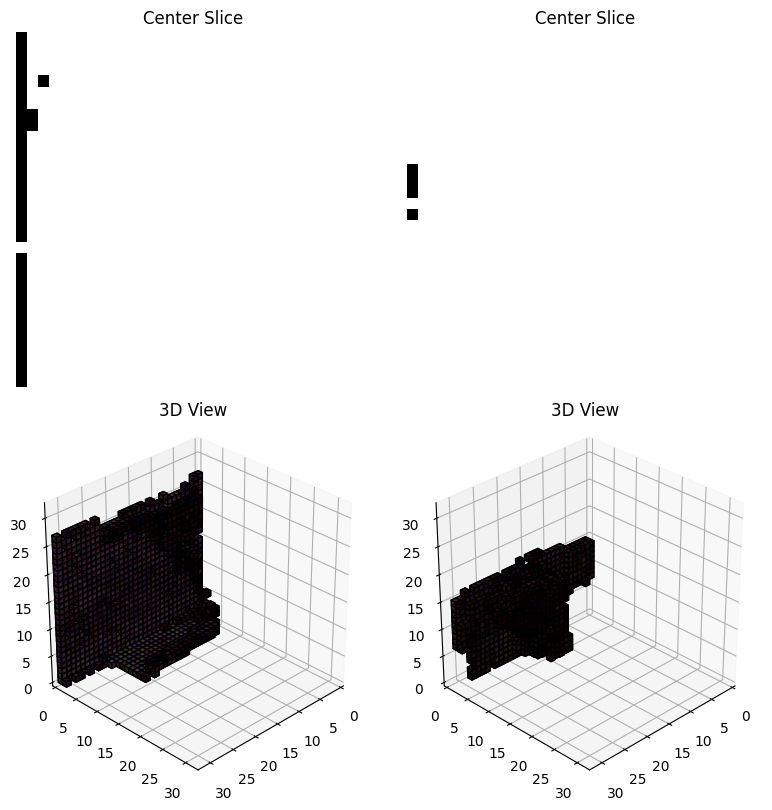

In [55]:
inferencer.visualize_samples(samples, threshold=0.5)

Number of vertices: 22656
Max face index: 22655
Number of faces: 33984


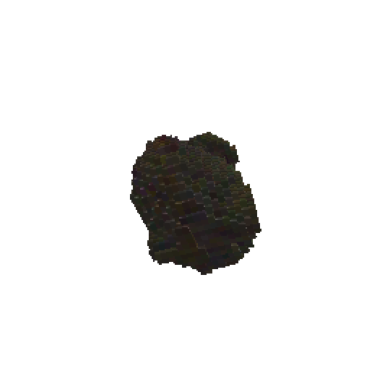

In [50]:
inferencer.visualize_samples_p3d(samples[0], threshold=0.5)

RGB range: [0.000, 1.000]
Alpha range: [0.000, 1.000]
Occupied voxels: 1551 (4.73% of volume)


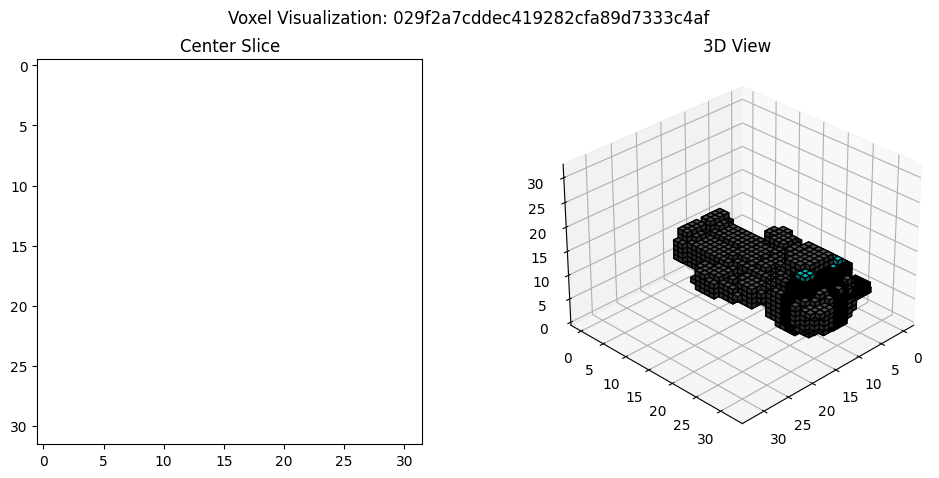

In [24]:
from blockgen.utils import plot_voxel_tensor

plot_voxel_tensor("objaverse_data_voxelized/hf-objaverse-v1/glbs/000-019/029f2a7cddec419282cfa89d7333c4af.pt")